In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from kdelearn.kde import KDE
from kdelearn.kde_tasks import KDEOutliersDetection
from kdelearn.bandwidth_selection import direct_plugin

In [2]:
data = pd.read_csv("../../data/crime_against_women_india/crimes_against_women_2001-2014.csv")

data = data[data["Year"] <= 2010]
data = data[~data["DISTRICT"].isin(["EAST", "RAILWAYS", "NORTH", "WEST", "SOUTH", "TOTAL", "G.R.P."])]
data.shape

(6894, 11)

In [3]:
tmp = data.groupby(["STATE/UT", "DISTRICT"]).size().reset_index()
tmp = tmp[tmp[0]==10]
tmp = tmp.reset_index(drop=True)

data = data.merge(tmp, "inner", ["STATE/UT", "DISTRICT"])
data.shape

(6280, 12)

In [4]:
data["STATE/UT"].value_counts()

UTTAR PRADESH        690
MADHYA PRADESH       480
BIHAR                440
MAHARASHTRA          440
TAMIL NADU           350
ODISHA               340
KARNATAKA            300
GUJARAT              300
RAJASTHAN            290
ANDHRA PRADESH       270
ASSAM                260
JHARKHAND            240
WEST BENGAL          210
HARYANA              200
JAMMU & KASHMIR      200
CHHATTISGARH         180
PUNJAB               170
UTTARAKHAND          130
ARUNACHAL PRADESH    130
HIMACHAL PRADESH     120
KERALA               110
NAGALAND             100
MIZORAM               80
MEGHALAYA             70
MANIPUR               70
DELHI                 30
GOA                   20
DAMAN & DIU           20
TRIPURA               10
CHANDIGARH            10
D & N HAVELI          10
LAKSHADWEEP           10
Name: STATE/UT, dtype: int64

In [5]:
data["DISTRICT"].value_counts()

HAMIRPUR       20
BILASPUR       20
BALRAMPUR      20
ADILABAD       10
MALKANGIR      10
               ..
BOKARO         10
CHAIBASA       10
CHATRA         10
DEOGHAR        10
LAKSHADWEEP    10
Name: DISTRICT, Length: 625, dtype: int64

In [6]:
data["Year"].value_counts()

2001    628
2002    628
2003    628
2004    628
2005    628
2006    628
2007    628
2008    628
2009    628
2010    628
Name: Year, dtype: int64

In [7]:
data

,Unnamed: 0,STATE/UT,DISTRICT,Year,Rape,Kidnapping and Abduction,Dowry Deaths,Assault on women with intent to outrage her modesty,Insult to modesty of Women,Cruelty by Husband or his Relatives,Importation of Girls,0
0,0,ANDHRA PRADESH,ADILABAD,2001,50,30,16,149,34,175,0,10
1,716,ANDHRA PRADESH,ADILABAD,2002,37,32,20,174,63,240,0,10
2,1435,ANDHRA PRADESH,ADILABAD,2003,35,16,11,141,39,238,0,10
3,2163,ANDHRA PRADESH,ADILABAD,2004,50,42,14,135,71,296,0,10
4,2892,ANDHRA PRADESH,ADILABAD,2005,53,46,21,144,77,280,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...
6275,4360,LAKSHADWEEP,LAKSHADWEEP,2006,0,0,0,0,0,1,0,10
6276,5103,LAKSHADWEEP,LAKSHADWEEP,2007,1,0,0,2,0,2,0,10
6277,5864,LAKSHADWEEP,LAKSHADWEEP,2008,2,1,0,0,0,1,0,10
6278,6631,LAKSHADWEEP,LAKSHADWEEP,2009,1,0,0,0,0,0,0,10


\newpage

# Outliers detection

## "Rape" vs "Insult to modesty of Women"

In [31]:
x_train = data[["Rape", "Insult to modesty of Women"]].to_numpy(dtype=np.float64)
x_train.shape

(6280, 2)

Najlepszy mnożnik h: 10.000, r: 0.01, Wskaźnik: 0.311


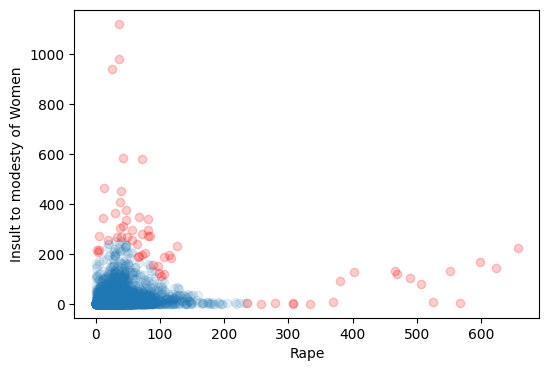

In [32]:
bandwidth = direct_plugin(x_train, stage=2)

metrics_list = []
h_mul_list = []
r_list = []
for h_mul in np.arange(0.5, 10.5, 0.5):
    h_mul = round(h_mul, 3)

    for r in np.arange(0.01, 0.31, 0.01):
        r = round(r, 3)

        kde = KDE().fit(x_train, bandwidth=bandwidth * h_mul)
        scores = kde.pdf(x_train)
        threshold = np.quantile(scores, r)
        labels_pred = np.where(scores <= threshold, 1, 0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
        scores_out = np.sort(scores[outliers])[-tmp:]
        scores_in = np.sort(scores[inliers])[:tmp]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        h_mul_list.append(h_mul)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*h_mul_list[idx], r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)

plt.figure(figsize=(6, 4))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.2, c="red")
plt.xlabel("Rape")
plt.ylabel("Insult to modesty of Women")
plt.show()

\newpage

## "Rape" vs "Assault on women with intent to outrage her modesty"

In [33]:
x_train = data[["Rape", "Assault on women with intent to outrage her modesty"]].to_numpy(dtype=np.float64)
x_train.shape

(6280, 2)

Najlepszy mnożnik h: 10.000, r: 0.01, Wskaźnik: 0.303


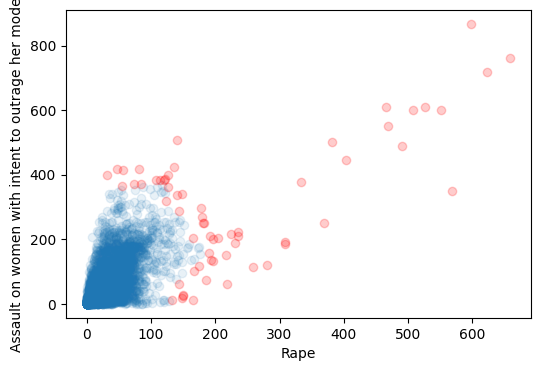

In [34]:
bandwidth = direct_plugin(x_train, stage=2)

metrics_list = []
h_mul_list = []
r_list = []
for h_mul in np.arange(0.5, 10.5, 0.5):
    h_mul = round(h_mul, 3)

    for r in np.arange(0.01, 0.31, 0.01):
        r = round(r, 3)

        kde = KDE().fit(x_train, bandwidth=bandwidth * h_mul)
        scores = kde.pdf(x_train)
        threshold = np.quantile(scores, r)
        labels_pred = np.where(scores <= threshold, 1, 0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
        scores_out = np.sort(scores[outliers])[-tmp:]
        scores_in = np.sort(scores[inliers])[:tmp]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        h_mul_list.append(h_mul)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*h_mul_list[idx], r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)

plt.figure(figsize=(6, 4))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.2, c="red")
plt.xlabel("Rape")
plt.ylabel("Assault on women with intent to outrage her modesty")
plt.show()

\newpage

## "Rape" vs "Cruelty by Husband or his Relatives"

In [35]:
x_train = data[["Rape", "Cruelty by Husband or his Relatives"]].to_numpy(dtype=np.float64)
x_train.shape

(6280, 2)

Najlepszy mnożnik h: 10.000, r: 0.01, Wskaźnik: 0.157


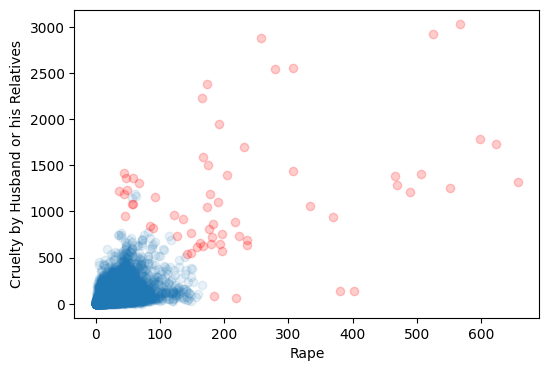

In [36]:
bandwidth = direct_plugin(x_train, stage=2)

metrics_list = []
h_mul_list = []
r_list = []
for h_mul in np.arange(0.5, 10.5, 0.5):
    h_mul = round(h_mul, 3)

    for r in np.arange(0.01, 0.31, 0.01):
        r = round(r, 3)

        kde = KDE().fit(x_train, bandwidth=bandwidth * h_mul)
        scores = kde.pdf(x_train)
        threshold = np.quantile(scores, r)
        labels_pred = np.where(scores <= threshold, 1, 0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
        scores_out = np.sort(scores[outliers])[-tmp:]
        scores_in = np.sort(scores[inliers])[:tmp]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        h_mul_list.append(h_mul)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*h_mul_list[idx], r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)

plt.figure(figsize=(6, 4))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.2, c="red")
plt.xlabel("Rape")
plt.ylabel("Cruelty by Husband or his Relatives")
plt.show()

\newpage

## "Assault on women with intent to outrage her modesty" vs "Insult to modesty of Women"

In [37]:
x_train = data[["Assault on women with intent to outrage her modesty", "Insult to modesty of Women"]].to_numpy(dtype=np.float64)
x_train.shape

(6280, 2)

Najlepszy mnożnik h: 10.000, r: 0.01, Wskaźnik: 0.367


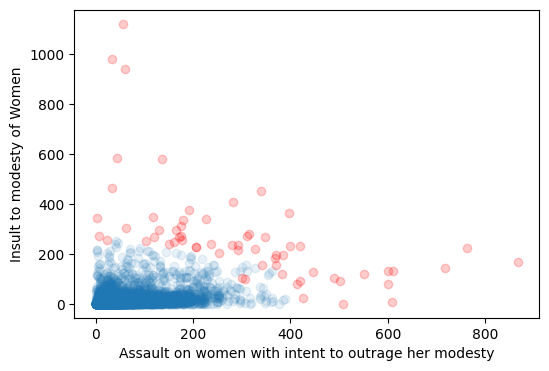

In [38]:
bandwidth = direct_plugin(x_train, stage=2)

metrics_list = []
h_mul_list = []
r_list = []
for h_mul in np.arange(0.5, 10.5, 0.5):
    h_mul = round(h_mul, 3)

    for r in np.arange(0.01, 0.31, 0.01):
        r = round(r, 3)

        kde = KDE().fit(x_train, bandwidth=bandwidth * h_mul)
        scores = kde.pdf(x_train)
        threshold = np.quantile(scores, r)
        labels_pred = np.where(scores <= threshold, 1, 0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
        scores_out = np.sort(scores[outliers])[-tmp:]
        scores_in = np.sort(scores[inliers])[:tmp]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        h_mul_list.append(h_mul)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*h_mul_list[idx], r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)

plt.figure(figsize=(6, 4))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.2, c="red")
plt.xlabel("Assault on women with intent to outrage her modesty")
plt.ylabel("Insult to modesty of Women")
plt.show()

\newpage

## "Assault on women with intent to outrage her modesty" vs "Cruelty by Husband or his Relatives"

In [39]:
x_train = data[["Assault on women with intent to outrage her modesty", "Cruelty by Husband or his Relatives"]].to_numpy(dtype=np.float64)
x_train.shape

(6280, 2)

Najlepszy mnożnik h: 10.000, r: 0.01, Wskaźnik: 0.304


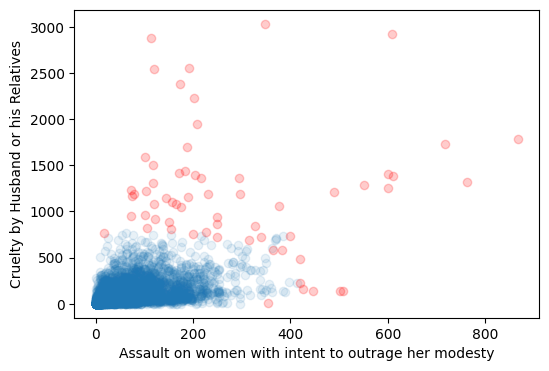

In [40]:
bandwidth = direct_plugin(x_train, stage=2)

metrics_list = []
h_mul_list = []
r_list = []
for h_mul in np.arange(0.5, 10.5, 0.5):
    h_mul = round(h_mul, 3)

    for r in np.arange(0.01, 0.31, 0.01):
        r = round(r, 3)

        kde = KDE().fit(x_train, bandwidth=bandwidth * h_mul)
        scores = kde.pdf(x_train)
        threshold = np.quantile(scores, r)
        labels_pred = np.where(scores <= threshold, 1, 0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
        scores_out = np.sort(scores[outliers])[-tmp:]
        scores_in = np.sort(scores[inliers])[:tmp]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        h_mul_list.append(h_mul)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*h_mul_list[idx], r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)

plt.figure(figsize=(6, 4))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.2, c="red")
plt.xlabel("Assault on women with intent to outrage her modesty")
plt.ylabel("Cruelty by Husband or his Relatives")
plt.show()

\newpage

## "Insult to modesty of Women" vs "Cruelty by Husband or his Relatives"

In [41]:
x_train = data[["Insult to modesty of Women", "Cruelty by Husband or his Relatives"]].to_numpy(dtype=np.float64)
x_train.shape

(6280, 2)

Najlepszy mnożnik h: 10.000, r: 0.01, Wskaźnik: 0.369


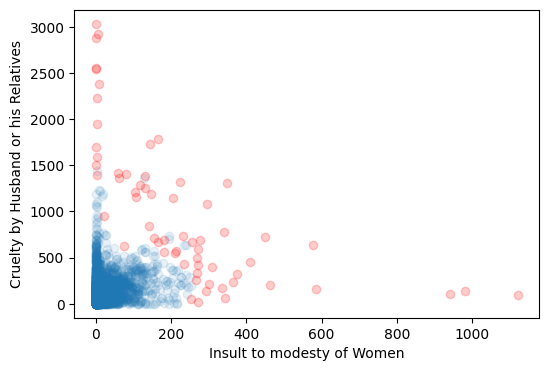

In [42]:
bandwidth = direct_plugin(x_train, stage=2)

metrics_list = []
h_mul_list = []
r_list = []
for h_mul in np.arange(0.5, 10.5, 0.5):
    h_mul = round(h_mul, 3)

    for r in np.arange(0.01, 0.31, 0.01):
        r = round(r, 3)

        kde = KDE().fit(x_train, bandwidth=bandwidth * h_mul)
        scores = kde.pdf(x_train)
        threshold = np.quantile(scores, r)
        labels_pred = np.where(scores <= threshold, 1, 0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
        scores_out = np.sort(scores[outliers])[-tmp:]
        scores_in = np.sort(scores[inliers])[:tmp]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        h_mul_list.append(h_mul)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*h_mul_list[idx], r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)

plt.figure(figsize=(6, 4))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.2, c="red")
plt.xlabel("Insult to modesty of Women")
plt.ylabel("Cruelty by Husband or his Relatives")
plt.show()